In [182]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz, circulant
from matplotlib import pyplot as plt
import config
import models
import tasks
import networks
import plots
import argparse
import json
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
import numpy as np
import pathlib
from sklearn.manifold import TSNE

In [183]:
noise_amplitude = 0.1 #*0
dim_recurrent = 100
simple_input = False
simple_output = True
hold_zero=False
redo_preanalysis = True # None = redo only if necessary

ORI_RES = 3

hold_orientation_for = 10
hold_cue_for = 100
delay0_set = torch.tensor([0]) 
delay0_set = torch.arange(30, 50)
delay1_set = torch.arange(30, 50)
delay2_set = torch.arange(30, 50)
delay0, delay1, delay2 = 40, 40, 40

total_time = hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2

orientation_neurons = 32
task = tasks.TWO_ORIENTATIONS_DOUBLE_OUTPUT(orientation_neurons, hold_orientation_for, hold_cue_for, delay0_set, delay1_set, delay2_set,
                                        simple_input=simple_input, simple_output=simple_output)
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")

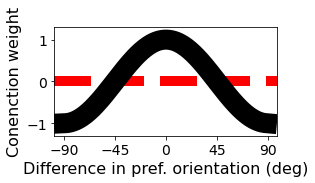

In [184]:
def weight(pref1, pref2):
    return 1 * ( torch.cos(2*(pref1-pref2)/180 * np.pi))
    a = 0.5
    return np.maximum(np.minimum(1+a-torch.abs(pref1-pref2)/90 * 2*(1+a), 1.), -1.)
def weight_ns(pref1, pref2):
    return 1
N = torch.arange(-90, 90, 1)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(4, 2))
plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth=10)
plt.plot(N, weight(N, 0), linewidth=20, color="k")
plt.xlabel('Difference in pref. orientation (deg)', fontsize=16)
plt.ylabel('Conenction weight', fontsize=16)
plt.xticks([-90, -45, 0, 45, 90])
plt.ylim(-1.3, 1.3)
plt.show()

In [185]:
def new_model():
    model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
    with torch.no_grad():
        model.fc_x2ah.weight[:, :] = 0
        model.fc_x2ah.bias[:] = 0
        model.fc_h2ah.weight[:, :] = 0
        model.fc_h2y.weight[:, :] = 0
        model.fc_h2y.bias[:] = 0
    return model
def save_model(model):
    torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")
def put_weights(model, units_from, units_to, units_from_pref=None, units_to_pref=None, weight_fun=weight, m=None, m_s=None):
    if type(units_from) is str: units_from = units_from.upper()
    
    uf_N = orientation_neurons if units_from=="IN" else len(units_from)
    ut_N = len(units_to)
    if m_s is not None: m = m_s / uf_N / ut_N
    if m is None: m = 1
    magnitude = m
    if units_from_pref is None:
        units_from_pref = torch.arange(uf_N) * 180 / uf_N
    if units_to_pref is None:
        units_to_pref = torch.arange(ut_N) * 180 / ut_N
    
    if units_from == "IN":
        units_from = torch.arange(orientation_neurons)
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_x2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
    else:
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_h2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
def put_bias(model, units_to, m=None, m_s=None):
    ut_N = len(units_to)
    if m_s is not None: m = m_s / 32 / ut_N
    if m is None: m = 1
    magnitude = m
    with torch.no_grad():
        model.fc_x2ah.bias[units_to] = magnitude

## R1 stronger than R2

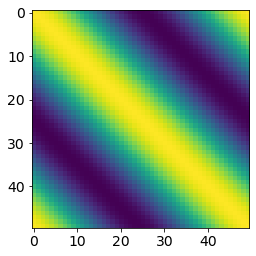

In [175]:
R1_N = 50
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 50
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
plt.imshow(R1_W)
R1_i = range(50)
R2_i = range(50, 100)

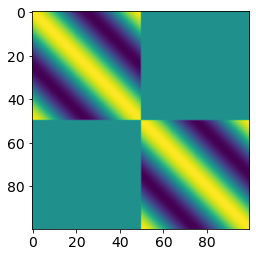

In [176]:
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[:50, :-1] = IN_R1_W * 0.10
    model.fc_x2ah.weight[50:, :-1] = IN_R1_W * 2.0
    model.fc_x2ah.bias[:] = -.2
    model.fc_h2ah.weight[:50, :50] = R1_W * 0.2
    model.fc_h2ah.weight[50:, 50:] = R2_W * 0.2
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.0725
plt.imshow(model.fc_h2ah.weight.detach().numpy())

In [177]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

## Gate blocks info to R1

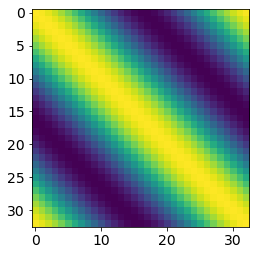

In [186]:
R1_N = 33
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 34
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 33
DT_pref = torch.arange(DT_N) * 180 / DT_N
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

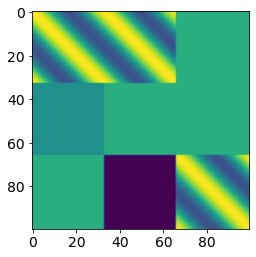

In [187]:
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[R2_i, :-1] = IN_R2_W * 0.3
    model.fc_x2ah.weight[DT_i, :-1] = IN_DT_W * 0.3
    model.fc_x2ah.weight[R1_i, :-1] = IN_R1_W * 0.0
    model.fc_x2ah.bias[:] = -.2
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(R1_i):max(R1_i)+1] = R1_W * 0.3
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(R2_i):max(R2_i)+1] = R2_W * 0.3
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_R1_W * 0.3
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(R1_i):max(R1_i)+1] = (-1) * .1
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(DT_i):max(DT_i)+1] = (-1) * .5
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * R1_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * R1_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.1
plt.imshow(model.fc_h2ah.weight.detach().numpy())

In [188]:
model.fc_h2y.weight.shape

torch.Size([4, 100])

In [189]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

## R2 flips DT

In [ ]:
R1_N = 33
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 34
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 33
DT_pref = torch.arange(DT_N) * 180 / DT_N
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

## R1 changes tunings a bit    

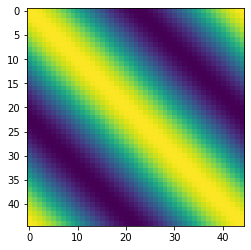

In [101]:
R1_N = 45
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 45
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        c = 0
        if (i*17)%IN_N < IN_N//3: c = -1
        if (i*17)%IN_N > (IN_N*2)//3: c = 1
        c *= 20*0
        
        c = (i*7)%IN_N - IN_N//2
        c *= 4.0
        #c = 0
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j]-c) * 1#(1+ 0*0.1*2*(((i*11)%IN_N)/IN_N-0.5))
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 10
DT_pref = torch.arange(DT_N) * 180 / DT_N
DT_W = torch.zeros(DT_N, DT_N)
for i in range(DT_N):
    for j in range(DT_N):
        DT_W[i, j] = weight(DT_pref[i], DT_pref[j])
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

In [102]:
fixed_R1_pref=torch.tensor([174., 178.,   2.,   6.,  11.,  15.,  20.,  24.,  29.,  34.,  39.,  43.,
         47.,  51.,  54.,  58.,  61.,  66.,  70.,  73.,  76.,  80.,  83.,  87.,
         91.,  95.,  99., 104., 108., 113., 117., 121., 126., 130., 135., 139.,
        143., 146., 151., 154., 158., 161., 165., 168., 171.])

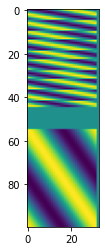

In [103]:
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[R2_i, :-1] = IN_R2_W * 0.3
    model.fc_x2ah.weight[DT_i, :-1] = IN_DT_W * 0.0
    model.fc_x2ah.weight[R1_i, :-1] = IN_R1_W * 0.3
    model.fc_x2ah.bias[:] = -.2
    model.fc_x2ah.bias[DT_i] = .2
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(R1_i):max(R1_i)+1] = R1_W * 0.3
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_W * 0.0
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(R2_i):max(R2_i)+1] = R2_W * 0.3
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_R1_W * 0.0
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(R1_i):max(R1_i)+1] = (-1) * .1 * .1 *.5
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(DT_i):max(DT_i)+1] = (-1) * .5 * 1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (fixed_R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (fixed_R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.0725
plt.imshow(model.fc_h2ah.weight.detach().numpy())
plt.imshow(model.fc_x2ah.weight.detach().numpy())

In [104]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

## R1 does not change tuning

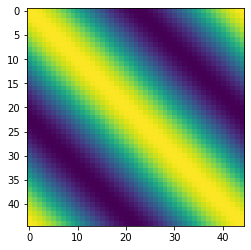

In [255]:
R1_N = 45
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 45
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        c = 0
        if (i*17)%IN_N < IN_N//3: c = -1
        if (i*17)%IN_N > (IN_N*2)//3: c = 1
        c *= 20*0
        
        c = (i*7)%IN_N - IN_N//2
        c *= 4.0 * 0
        #c = 0
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j]-c) * 1#(1+ 0*0.1*2*(((i*11)%IN_N)/IN_N-0.5))
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 10
DT_pref = torch.arange(DT_N) * 180 / DT_N
DT_W = torch.zeros(DT_N, DT_N)
for i in range(DT_N):
    for j in range(DT_N):
        DT_W[i, j] = weight(DT_pref[i], DT_pref[j])
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

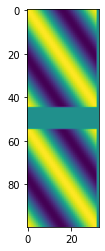

In [262]:
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[R2_i, :-1] = IN_R2_W * 0.3
    model.fc_x2ah.weight[DT_i, :-1] = IN_DT_W * 0.0
    model.fc_x2ah.weight[R1_i, :-1] = IN_R1_W * 0.3
    model.fc_x2ah.bias[:] = -.2
    model.fc_x2ah.bias[DT_i] = .2
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(R1_i):max(R1_i)+1] = R1_W * 0.25
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_W * 0.0
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(R2_i):max(R2_i)+1] = R2_W * 0.3
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_R1_W * 0.0
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(R1_i):max(R1_i)+1] = (-1) * .1 * .1 *.5
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(DT_i):max(DT_i)+1] = (-1) * .5 * 1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.0725
plt.imshow(model.fc_h2ah.weight.detach().numpy())
plt.imshow(model.fc_x2ah.weight.detach().numpy())

## R1 changes tuning, R2 decays

In [105]:
def new_model():
    model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
    with torch.no_grad():
        model.fc_x2ah.weight[:, :] = 0
        model.fc_x2ah.bias[:] = 0
        model.fc_h2ah.weight[:, :] = 0
        model.fc_h2y.weight[:, :] = 0
        model.fc_h2y.bias[:] = 0
    return model
def save_model(model):
    torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")
def put_weights(model, units_from, units_to, units_from_pref=None, units_to_pref=None, weight_fun=weight, m=None, m_s=None):
    if type(units_from) is str: units_from = units_from.upper()
    
    uf_N = orientation_neurons if units_from=="IN" else len(units_from)
    ut_N = len(units_to)
    if m_s is not None: m = m_s / uf_N / ut_N
    if m is None: m = 1
    magnitude = m
    if units_from_pref is None:
        units_from_pref = torch.arange(uf_N) * 180 / uf_N
    if units_to_pref is None:
        units_to_pref = torch.arange(ut_N) * 180 / ut_N
    
    if units_from == "IN":
        units_from = torch.arange(orientation_neurons)
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_x2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
    else:
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_h2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
def put_bias(model, units_to, m=None, m_s=None):
    ut_N = len(units_to)
    if m_s is not None: m = m_s / 32 / ut_N
    if m is None: m = 1
    magnitude = m
    with torch.no_grad():
        model.fc_x2ah.bias[units_to] = magnitude

In [106]:
R1_N = 45
R2_N = 45
DT_N = 10
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1, R2, DT = R1_i, R2_i, DT_i
R1_pref = torch.arange(len(R1))/len(R1)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

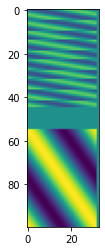

In [107]:
model = new_model()
for j, i in enumerate(R1):
    in_pref_shift = ((j*7)%orientation_neurons - orientation_neurons/2)*4
    in_pref = torch.arange(orientation_neurons)/orientation_neurons * 180 - in_pref_shift
    put_weights(model, "IN", [i], units_from_pref=in_pref, units_to_pref=R1_pref[j:j+1], m=0.16)
#put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R1, R1, m=0.16)
#put_weights(model, DT, DT, m=0.16*R1_N/DT_N)
put_weights(model, R2, R2, m=0.16)

put_weights(model, R1, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N)

put_bias(model, R1, m=-0.06)
put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

## R1 changes tuning, R2 gated

In [168]:
R1_N = 45
R2_N = 45
DT_N = 10
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1, R2, DT = R1_i, R2_i, DT_i
R1_pref = torch.arange(len(R1))/len(R1)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

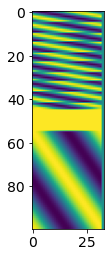

In [169]:
model = new_model()
for j, i in enumerate(R1):
    in_pref_shift = ((j*7)%orientation_neurons - orientation_neurons/2)*4
    in_pref = torch.arange(orientation_neurons)/orientation_neurons * 180 - in_pref_shift
    put_weights(model, "IN", [i], units_from_pref=in_pref, units_to_pref=R1_pref[j:j+1], m=0.3)#16)
#put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R2, m=0.3)
put_weights(model, "IN", DT, m=0.3, weight_fun=weight_ns)

put_weights(model, R1, R1, m=0.16)
#put_weights(model, DT, DT, m=0.16*R1_N/DT_N)
put_weights(model, R2, R2, m=0.16)

put_weights(model, R1, DT, units_to_pref=DT_pref, m=-0.1, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1, m=-0.06)
put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

In [170]:
import random
random.randint(-60, 60)

-8

In [171]:
R1_pref_fixed = torch.tensor([ 18.,  21.,  25.,  28.,  31.,  34.,  38.,  42.,  45.,  50.,  54.,  58.,
         62.,  66.,  71.,  74.,  79.,  83.,  87.,  92.,  96., 101., 105., 108.,
        112., 116., 120., 124., 128., 132., 135., 139., 142., 146., 150., 153.,
        158., 162., 167., 172., 177.,   1.,   5.,  10.,  13.])

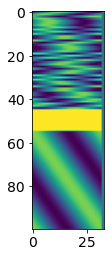

In [174]:
# RANDOM tuning change
model = new_model()
random.seed(1337)
for j, i in enumerate(R1):
    in_pref_shift = random.randint(-70, 70)#((j*7)%orientation_neurons - orientation_neurons/2)*4
    in_pref = torch.arange(orientation_neurons)/orientation_neurons * 180 - in_pref_shift
    put_weights(model, "IN", [i], units_from_pref=in_pref, units_to_pref=R1_pref[j:j+1], m=0.2)#16)
#put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R2, m=0.2)
put_weights(model, "IN", DT, m=0.3, weight_fun=weight_ns)

put_weights(model, R1, R1, m=0.2)
#put_weights(model, DT, DT, m=0.16*R1_N/DT_N)
put_weights(model, R2, R2, m=0.2)

put_weights(model, R1, DT, units_to_pref=DT_pref, m=-0.1, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1, m=-0.06)
put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

## Inversion of tuning

In [26]:
R1a_N = 23
R1b_N = 23
R1_N = R1a_N + R1b_N
R2_N = 44
DT_N = 10
R1a_i = torch.arange(0, R1a_N, dtype=int)
R1b_i = torch.arange(R1a_N, R1a_N+R1b_N, dtype=int)
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1a, R1b, R2, DT = R1a_i, R1b_i, R2_i, DT_i
R1a_pref = torch.arange(len(R1a))/len(R1a)*180
R1b_pref = torch.arange(len(R1b))/len(R1b)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

In [27]:
R1_pref_fixed = torch.tensor([  0.,   8.,  15.,  23.,  31.,  39.,  47.,  55.,  62.,  70.,  78.,  85.,
         94., 102., 109., 117., 125., 133., 141., 148., 156., 164., 173.,  90.,
         98., 106., 113., 120., 129., 137., 145., 151., 159., 168., 177.,   5.,
         11.,  19.,  27.,  35.,  43.,  51.,  59.,  66.,  74.,  81.])

In [34]:
model = new_model()
put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R1a, m=0.4)
put_weights(model, "IN", R1b, m=0.4)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)

put_weights(model, R1a, R1a, m=0.15)
put_weights(model, R1b, R1b, m=0.15)
put_weights(model, R1a, R1b, m=-0.2)
put_weights(model, R1b, R1a, m=-0.15)

put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N)

put_bias(model, R1a, m=-0.06)
put_bias(model, R1b, m=-0.06)
#put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.06)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

ZeroDivisionError: float division by zero

## Inversion of tuning, O1

In [111]:
R1a_N = 23
R1b_N = 23
R1_N = R1a_N + R1b_N
R2_N = 44
DT_N = 10
R1a_i = torch.arange(0, R1a_N, dtype=int)
R1b_i = torch.arange(R1a_N, R1a_N+R1b_N, dtype=int)
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1a, R1b, R2, DT = R1a_i, R1b_i, R2_i, DT_i
R1a_pref = torch.arange(len(R1a))/len(R1a)*180
R1b_pref = torch.arange(len(R1b))/len(R1b)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

In [78]:
R1_pref_fixed = torch.tensor([  1.,   8.,  16.,  23.,  32.,  40.,  47.,  55.,  63.,  70.,  78.,  86.,
         94., 102., 110., 117., 125., 134., 140., 149., 156., 164., 172.,  90.,
         98., 106., 114., 121., 130., 137., 145., 153., 161., 168., 177.,   4.,
         12.,  19.,  28.,  35.,  43.,  51.,  59.,  66.,  74.,  81.])

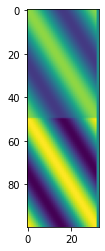

In [60]:
model = new_model()
put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R1a, m=0.2)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)

put_weights(model, R1a, R1a, m=0.2)
put_weights(model, R1b, R1b, m=0.2)
put_weights(model, R1a, R1b, m=-0.18)
put_weights(model, R1b, R1a, m=-0.1)

put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.1)
put_bias(model, R1b, m=-0.1)
#put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.06)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725/2.5
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725/2.5
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

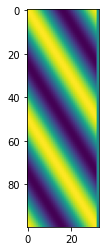

In [72]:
model = new_model()
put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R1a, m=0.3)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)

put_weights(model, R1a, R1a, m=0.17)
put_weights(model, R1b, R1b, m=0.15)
put_weights(model, R1a, R1b, m=-0.22)
put_weights(model, R1b, R1a, m=-0.15)

put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.095)
put_bias(model, R1b, m=-0.13)
#put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.06)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

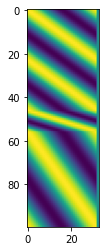

In [99]:
model = new_model()
put_weights(model, "IN", DT, m=0.3)#, weight_fun=weight_ns)
put_weights(model, "IN", R1a, m=0.3)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)
#put_weights(model, DT, DT, m=0.16)

put_weights(model, R1a, R1a, m=0.15*1.7)
put_weights(model, R1b, R1b, m=0.15*1.7)
put_weights(model, R1a, R1b, m=-0.2*2)
put_weights(model, R1b, R1a, m=-0.1*2)

#put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.3)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.08, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.1)
put_bias(model, R1b, m=-0.1)
put_bias(model, DT, m=-0.1)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1 
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

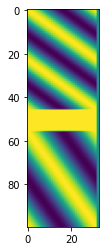

In [112]:
model = new_model()
put_weights(model, "IN", DT, m=0.3, weight_fun=weight_ns)
put_weights(model, "IN", R1a, m=0.3)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)
#put_weights(model, DT, DT, m=0.16)

put_weights(model, R1a, R1a, m=0.15*1.7)
put_weights(model, R1b, R1b, m=0.15*1.7)
put_weights(model, R1a, R1b, m=-0.2*2)
put_weights(model, R1b, R1a, m=-0.1*2)

#put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.3)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.15, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.1)
put_bias(model, R1b, m=-0.1)
#put_bias(model, DT, m=-0.1)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1 
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())